<a href="https://colab.research.google.com/github/rrezendes/marketing_campaign/blob/master/iFood_classification_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.Imports, connections and transformation

In [0]:
#@title Libraries importing
#@libraries
#importing libraries
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#pydrive to google drive connection
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials


In [0]:
#@title Authentication
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
#@title Reading the file
#google drive file link (ml_project1_data.csv)
link = 'https://drive.google.com/open?id=1EcraG_N9CYY-YPnf9AHCyag9GtKMl9oF' # The shareable link

#takes the file ID
fluff, id = link.split('=')

#download and csv read
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('ifood_file_test.csv')  
csv_base = pd.read_csv('ifood_file_test.csv')

In [0]:
#@title New Dataframe
df = csv_base


In [0]:
#@title Transformation 
column_means = df. mean()
df = df. fillna(column_means)

df['Frequency'] = df['NumCatalogPurchases'] + df['NumStorePurchases'] + df['NumWebPurchases']
df['Revenue'] = df['MntFishProducts'] + df['MntFruits'] + df['MntMeatProducts'] + df['MntSweetProducts'] + df['MntWines']
df = df.drop(['ID','NumCatalogPurchases','NumStorePurchases','NumWebPurchases'], axis=1)
df = df.drop(['Z_CostContact','Z_Revenue','MntFishProducts','MntFruits','MntMeatProducts','MntSweetProducts','MntWines'],axis=1)
df = df.drop(['Dt_Customer'], axis=1)


Random over-sampling:
1    1906
0    1906
Name: Response, dtype: int64


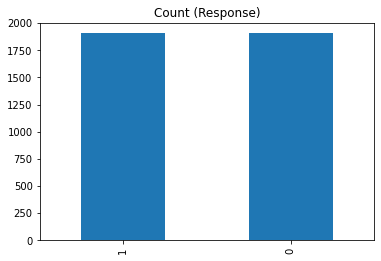

In [0]:
#@title Oversampling
# Class count
count_class_0, count_class_1 = df.Response.value_counts()

# Divide by class
df_class_0 = df[df['Response'] == 0]
df_class_1 = df[df['Response'] == 1]

df_class_1_over = df_class_1.sample(count_class_0, replace=True)
df_test_over = pd.concat([df_class_0, df_class_1_over], axis=0)

print('Random over-sampling:')
print(df_test_over.Response.value_counts())

df_test_over.Response.value_counts().plot(kind='bar', title='Count (Response)');

df_old = df
df = df_test_over

In [0]:
df.head()


,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntGoldProds,NumDealsPurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Frequency,Revenue
1,1954,Graduation,Single,46344.0,1,1,38,6,2,5,0,0,0,0,0,0,0,4,21
2,1965,Graduation,Together,71613.0,0,0,26,42,1,4,0,0,0,0,0,0,0,20,734
3,1984,Graduation,Together,26646.0,1,0,26,5,2,6,0,0,0,0,0,0,0,6,48
4,1981,PhD,Married,58293.0,1,0,94,15,5,5,0,0,0,0,0,0,0,14,407
5,1967,Master,Together,62513.0,0,1,16,14,2,6,0,0,0,0,0,0,0,20,702


# 2. Classification Model

## 2.1 Dataframe informations

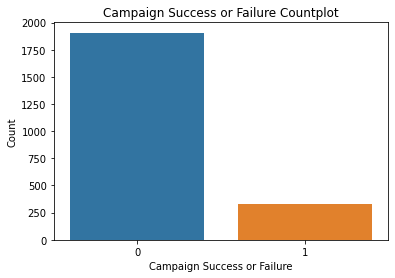

In [0]:
#@title Response (before oversampling)
sns.countplot(df_old['Response']);
plt.xlabel('Campaign Success or Failure'); 
plt.ylabel('Count'); plt.title('Campaign Success or Failure Countplot');

#sns.countplot('SuccessfulBool', data=df)

In [0]:
#@title Info
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3812 entries, 1 to 397
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Year_Birth         3812 non-null   int64  
 1   Education          3812 non-null   object 
 2   Marital_Status     3812 non-null   object 
 3   Income             3812 non-null   float64
 4   Kidhome            3812 non-null   int64  
 5   Teenhome           3812 non-null   int64  
 6   Recency            3812 non-null   int64  
 7   MntGoldProds       3812 non-null   int64  
 8   NumDealsPurchases  3812 non-null   int64  
 9   NumWebVisitsMonth  3812 non-null   int64  
 10  AcceptedCmp3       3812 non-null   int64  
 11  AcceptedCmp4       3812 non-null   int64  
 12  AcceptedCmp5       3812 non-null   int64  
 13  AcceptedCmp1       3812 non-null   int64  
 14  AcceptedCmp2       3812 non-null   int64  
 15  Complain           3812 non-null   int64  
 16  Response           3812 n

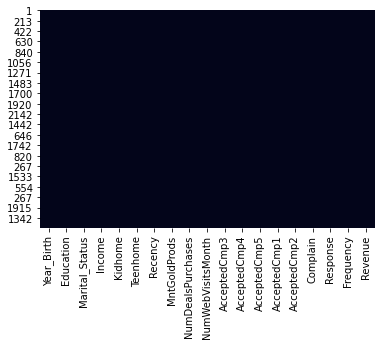

In [0]:
#@title Null values
sns.heatmap(df.isnull(), cbar=False)

## 2.2. Outliers

In [0]:
#@title Outliers
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Year_Birth,3812.0,1969.014953,12.223775,1893.0,1959.0,1970.0,1978.00,1996.0
Income,3812.0,55548.044540,24587.372343,1730.0,37070.0,55320.5,74128.25,666666.0
Kidhome,3812.0,0.401364,0.521365,0.0,0.0,0.0,1.00,2.0
Teenhome,3812.0,0.421039,0.533140,0.0,0.0,0.0,1.00,2.0
Recency,3812.0,43.697009,29.311343,0.0,17.0,41.0,69.00,99.0
MntGoldProds,3812.0,51.714586,55.238909,0.0,13.0,31.0,71.25,362.0
NumDealsPurchases,3812.0,2.313221,1.963456,0.0,1.0,2.0,3.00,15.0
NumWebVisitsMonth,3812.0,5.308499,2.488873,0.0,3.0,6.0,7.00,20.0
AcceptedCmp3,3812.0,0.138510,0.345480,0.0,0.0,0.0,0.00,1.0
AcceptedCmp4,3812.0,0.123820,0.329419,0.0,0.0,0.0,0.00,1.0


In [0]:
#@title Generate Interquartile Range
first_quartile = df['Income'].describe()['25%']

third_quartile = df['Income'].describe()['75%']

iqr = third_quartile - first_quartile

df_income_iqr = df[(df['Income'] > first_quartile) & (df['Income'] < third_quartile)]

#-------------------------------------------------------------------------

df_iqr_trimmed = df_income_iqr

first_quartile = df['MntGoldProds'].describe()['25%']
third_quartile = df['MntGoldProds'].describe()['75%']

iqr = third_quartile - first_quartile

df_iqr_trimmed = df[(df['MntGoldProds'] > first_quartile) & (df['MntGoldProds'] < third_quartile)]

#-------------------------------------------------------------------


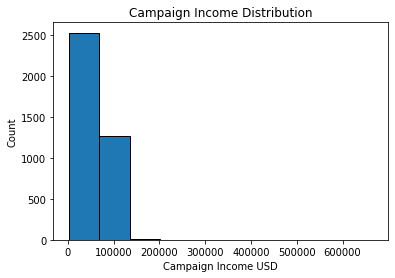

In [0]:
#@title Before Interquartile (Income)
plt.hist(df['Income'], edgecolor = 'black');
plt.xlabel('Campaign Income USD'); 
plt.ylabel('Count'); plt.title('Campaign Income Distribution');

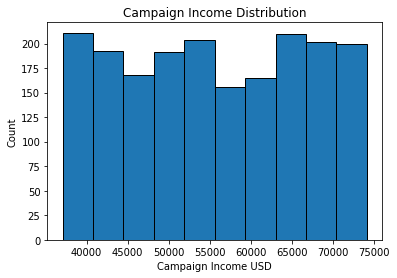

In [0]:
#@title After Interquartile
# Histogram Plot of Site EUI
#plt.figure.figsize(8, 8)
plt.hist(df_income_iqr['Income'], edgecolor = 'black');
plt.xlabel('Campaign Income USD'); 
plt.ylabel('Count'); plt.title('Campaign Income Distribution');


In [0]:
#@title Correlation
df_income_iqr.corr()['Response'].sort_values()

Recency             -0.280966
Teenhome            -0.192134
Year_Birth          -0.043891
Kidhome             -0.035676
Income               0.050407
Complain             0.068851
MntGoldProds         0.131955
NumDealsPurchases    0.144030
AcceptedCmp2         0.146799
AcceptedCmp4         0.158420
NumWebVisitsMonth    0.196895
Frequency            0.205070
AcceptedCmp5         0.213852
AcceptedCmp1         0.215330
AcceptedCmp3         0.246536
Revenue              0.289796
Response             1.000000
Name: Response, dtype: float64

In [0]:
#@title Outlier treatment
#df_iqr_trimmed = df_iqr_trimmed
df_iqr_trimmed.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Year_Birth,726.0,1970.005510,11.401995,1943.0,1962.00,1972.0,1979.00,1992.0
Income,726.0,46283.973837,18898.140640,7500.0,31389.00,43858.0,62789.75,85693.0
Kidhome,726.0,0.568871,0.525300,0.0,0.00,1.0,1.00,2.0
Teenhome,726.0,0.498623,0.524567,0.0,0.00,0.0,1.00,2.0
Recency,726.0,45.907713,28.898367,0.0,23.00,43.0,69.75,99.0
MntGoldProds,726.0,41.969697,49.109973,0.0,11.00,23.0,50.00,247.0
NumDealsPurchases,726.0,2.000000,0.000000,2.0,2.00,2.0,2.00,2.0
NumWebVisitsMonth,726.0,5.946281,1.718421,1.0,5.00,6.0,7.00,9.0
AcceptedCmp3,726.0,0.183196,0.387093,0.0,0.00,0.0,0.00,1.0
AcceptedCmp4,726.0,0.064738,0.246233,0.0,0.00,0.0,0.00,1.0


In [0]:
#@title Correlation
df_iqr_trimmed.corr()['Response'].sort_values()

Teenhome            -0.384696
Recency             -0.209873
Income              -0.040478
Frequency            0.062922
Kidhome              0.094113
AcceptedCmp2         0.094764
MntGoldProds         0.107260
Complain             0.122140
AcceptedCmp4         0.139061
AcceptedCmp1         0.145329
Year_Birth           0.150181
AcceptedCmp5         0.160313
Revenue              0.164369
NumWebVisitsMonth    0.226020
AcceptedCmp3         0.434354
Response             1.000000
NumDealsPurchases         NaN
Name: Response, dtype: float64

## 2.3. Feature Engineering

In [0]:
#@title Reduced features

#reduced_x_features = df_iqr_trimmed.select_dtypes('number')
#reduced_x_features = reduced_x_features.drop(['Response'], axis=1)

#reduced_x_features = df_iqr_trimmed[[ 'Teenhome','Recency','Revenue','NumWebVisitsMonth','AcceptedCmp3']]

#99 RF
#reduced_x_features = df_iqr_trimmed[[ 'Teenhome','Recency','AcceptedCmp1','AcceptedCmp4','Frequency','Revenue','NumWebVisitsMonth','AcceptedCmp3']]

reduced_x_features = df_iqr_trimmed[[ 'Teenhome','Recency','Frequency','Revenue','NumWebVisitsMonth','AcceptedCmp3']]

reduced_y = df_iqr_trimmed['Response']



In [0]:
#@title Numeric subset
# Select the numeric columns
numeric_subset = df_iqr_trimmed.select_dtypes('number')
numeric_subset.head()

,Year_Birth,Income,Kidhome,Teenhome,Recency,MntGoldProds,NumDealsPurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Frequency,Revenue
1,1954,46344.0,1,1,38,6,2,5,0,0,0,0,0,0,0,4,21
3,1984,26646.0,1,0,26,5,2,6,0,0,0,0,0,0,0,6,48
5,1967,62513.0,0,1,16,14,2,6,0,0,0,0,0,0,0,20,702
7,1985,33454.0,1,0,32,23,2,8,0,0,0,0,0,0,0,8,146
17,1946,37760.0,0,0,20,28,2,7,0,0,0,0,0,0,0,11,289


In [0]:
#@title Log numeric
# Create columns with square root and log of numeric columns
for col in numeric_subset.columns:
    # Skip the Energy Star Score column
    if col == 'Response':
        next
    else:
        numeric_subset['sqrt_' + col] = np.sqrt(numeric_subset[col])
        numeric_subset['log_' + col] = np.log(numeric_subset[col])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [0]:
#@title Categorical subset
# Select the categorical columns
#categorical_subset = df_iqr_trimmed[['Education','Marital_Status','Year_Birth']]
categorical_subset = df_iqr_trimmed[['Education','Marital_Status']]

# One hot encode
categorical_subset = pd.get_dummies(categorical_subset)

# Join the two dataframes using concat
# Make sure to use axis = 1 to perform a column bind
features = pd.concat([numeric_subset, categorical_subset], axis = 1)

# Drop buildings without an energy star score
features = features.dropna(subset = ['Response'])



In [0]:
#@title Score correlations
# Find correlations with the score 
correlations = features.corr()['Response'].dropna().sort_values()
correlations.head()
#reduced_x_features['log_Recency'] = features['log_Recency']

sqrt_Teenhome   -0.386397
Teenhome        -0.384696
log_Recency     -0.234795
sqrt_Recency    -0.220266
Recency         -0.209873
Name: Response, dtype: float64

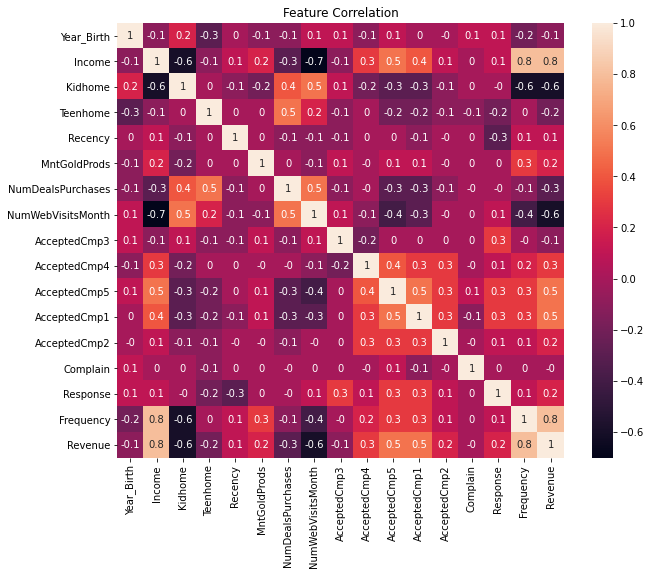

In [0]:
#@title Correlation
plt.figure(figsize = (10,8))
sns.heatmap(round(df_iqr_trimmed.corr(),1), annot=True);
plt.title("Feature Correlation");


## 2.4. Model

In [0]:
#@title Train test
from sklearn.model_selection import train_test_split

# Split into 70% training and 30% testing set
X, X_test, y, y_test = train_test_split(reduced_x_features, reduced_y, test_size = 0.20, random_state = 101)

print(X.shape)
print(X_test.shape)
print(y.shape)
print(y_test.shape)

(580, 6)
(146, 6)
(580,)
(146,)


In [0]:
#@title Model import
# Imputing missing values and scaling values
from sklearn.preprocessing import MinMaxScaler

# Machine Learning Models
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# Hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [0]:
#@title Fit and evaluate
from sklearn.metrics import classification_report, confusion_matrix

# Takes in a model, trains the model, and evaluates the model on the test set
def fit_and_evaluate(model):
    
    # Train the model
    model.fit(X, y)
    
    # Make predictions and evalute
    predictions = model.predict(X_test)
    
    # Return the performance metric
    return print(classification_report(y_test, predictions), '\n', confusion_matrix(y_test, predictions))

In [0]:
#@title Logistic Regression
lr = LogisticRegression()

fit_and_evaluate(lr)

              precision    recall  f1-score   support

           0       0.82      0.82      0.82        94
           1       0.67      0.67      0.67        52

    accuracy                           0.77       146
   macro avg       0.75      0.75      0.75       146
weighted avg       0.77      0.77      0.77       146
 
 [[77 17]
 [17 35]]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [0]:
#@title SVM (Support Vector Machine)
svm = SVC(C = 1000, gamma = 0.1)

fit_and_evaluate(svm)

              precision    recall  f1-score   support

           0       1.00      0.96      0.98        94
           1       0.93      1.00      0.96        52

    accuracy                           0.97       146
   macro avg       0.96      0.98      0.97       146
weighted avg       0.97      0.97      0.97       146
 
 [[90  4]
 [ 0 52]]


In [0]:
#@title Random forest
random_forest = RandomForestClassifier(random_state=101)

fit_and_evaluate(random_forest)

              precision    recall  f1-score   support

           0       1.00      0.97      0.98        94
           1       0.95      1.00      0.97        52

    accuracy                           0.98       146
   macro avg       0.97      0.98      0.98       146
weighted avg       0.98      0.98      0.98       146
 
 [[91  3]
 [ 0 52]]


In [0]:
#@title KNN
knn = KNeighborsClassifier(n_neighbors=5)

fit_and_evaluate(knn)

              precision    recall  f1-score   support

           0       0.95      0.78      0.85        94
           1       0.70      0.92      0.79        52

    accuracy                           0.83       146
   macro avg       0.82      0.85      0.82       146
weighted avg       0.86      0.83      0.83       146
 
 [[73 21]
 [ 4 48]]


In [0]:
#@title Gradient Boosted
gradient_boosted = GradientBoostingClassifier(random_state=60)

fit_and_evaluate(gradient_boosted)

              precision    recall  f1-score   support

           0       0.97      0.96      0.96        94
           1       0.92      0.94      0.93        52

    accuracy                           0.95       146
   macro avg       0.95      0.95      0.95       146
weighted avg       0.95      0.95      0.95       146
 
 [[90  4]
 [ 3 49]]


Confusion matrix:
 [[91  3]
 [ 0 52]]


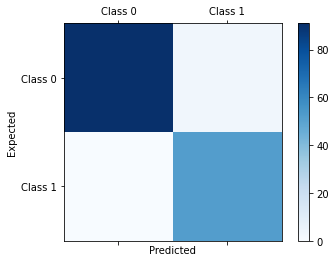

In [0]:
#@title Confusion Matrix (Random Forest)

conf_mat = confusion_matrix(y_true=y_test, y_pred=random_forest.predict(X_test))
print('Confusion matrix:\n', conf_mat)

labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

In [0]:
#@title Feature importance
importances = random_forest.feature_importances_

feature_list = list(X.columns)

feature_results = pd.DataFrame({'feature': feature_list,
                               'importance': importances})

feature_results

,feature,importance
0,Teenhome,0.119247
1,Recency,0.233745
2,Frequency,0.132581
3,Revenue,0.245307
4,NumWebVisitsMonth,0.130309
5,AcceptedCmp3,0.138810


## 2.5. Test

In [0]:
#gradient_boosted.predict_proba([[1, 20, 1, 1, 1000, 10, 20]])

In [0]:
random_forest.predict_proba([[0, 30, 10, 1000, 10, 1]])

array([[0.1, 0.9]])